In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

# Create Graph

In [2]:
pgp = np.loadtxt('data/PGPedges.csv', delimiter=',', dtype=int)

In [3]:
G = nx.Graph()
G.add_edges_from(pgp)

# (1)

In [4]:
C = nx.dfs_tree(G, 1)

In [5]:
len(C.nodes) == len(G.nodes)

True

# (2)

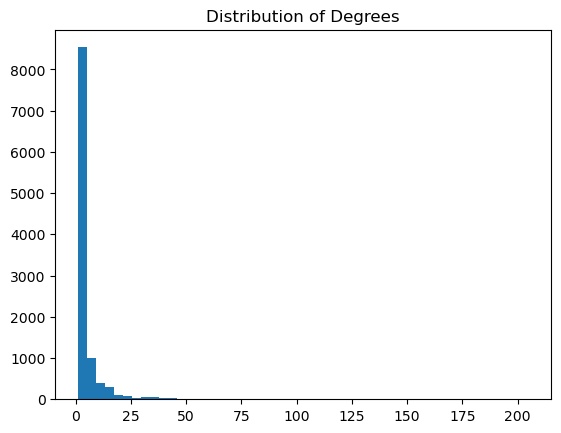

In [6]:
degrees = (np.asarray(list(nx.degree_centrality(G).values())) * (len(G.nodes) - 1)).astype(int)
plt.hist(degrees, bins=50)
plt.title('Distribution of Degrees')
plt.show()

## Linear-Binning

In [7]:
ks = np.arange(1, degrees.max()+1)
pks = np.empty(len(ks))
for k in ks:
    pks[int(k-1)] = (degrees == k).sum() / len(G.nodes)

## Log-Binning

In [8]:
bs = 2 ** np.arange(0, np.floor(np.log2(degrees.max())))
idx = np.concatenate([np.zeros(1), np.cumsum(bs)]).astype(int)
pks_log = np.empty(len(bs))
k_mean = np.empty(len(bs))
for i, (k_, k) in enumerate(zip(idx[:-1], idx[1:])):
    s = np.logical_and(k_ < degrees, degrees <= k)
    pks_log[i] = s.sum() / bs[i] / len(G.nodes)
    k_mean[i] = degrees[s].mean()

## Power Law

In [9]:
b = np.log(pks_log)
A = np.stack([
    np.ones_like(k_mean),
    - k_mean,
    - np.log(k_mean)
    ], axis=-1)
x = np.linalg.lstsq(A, b, rcond=None)[0]

In [10]:
C = np.exp(x[0])
alpha = x[1]
tau = x[2]
print(C, alpha, tau)

0.4667121626792623 0.04045413692081015 1.4108191879038672


In [11]:
def power_law(k):
    return C * np.exp(-alpha * k) * k ** (-tau)

## Plot

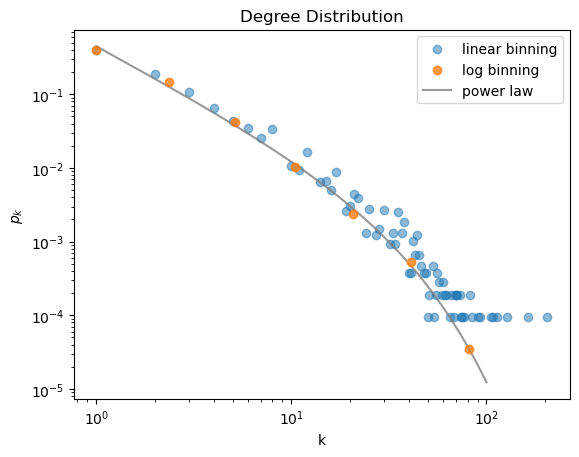

In [12]:
kk = np.linspace(1, 100, 100)
plt.scatter(ks, pks, alpha=0.5, label='linear binning')
plt.scatter(k_mean, pks_log, alpha=0.8, zorder=3, label='log binning')
plt.plot(kk, power_law(kk), alpha=0.8, c='grey', label='power law')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('$p_k$')
plt.legend()
plt.title('Degree Distribution')
plt.show()

# (3)

In [151]:
print(nx.average_shortest_path_length(G))

7.4855400514784

In [13]:
def li(s, x, n=10000):
    nn = np.arange(n) + 1
    zz = np.power(x, nn)
    dd = nn ** s
    return np.sum(zz / dd)

def mean_length(alpha, tau, n=10000):
    e = np.exp(-alpha)
    num = np.log(len(G.nodes)) + np.log(li(tau, e, n) / li(tau-1, e, n))
    den = np.log(li(tau-2, e, n) / li(tau-1, e, n) - 1)
    return num / den + 1

In [14]:
mean_length(alpha, tau)

3.862654118456116

# (4)

In [15]:
E = nx.adjacency_matrix(G)

C:\Users\geniu\AppData\Local\Temp\ipykernel_25956\2548789208.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  E = nx.adjacency_matrix(G)


In [25]:
num_path2 = np.triu((E @ E).toarray(), k=1).sum()
num_closed = sum(list(nx.triangles(G).values())) # each triangle is counted 3 times
c_cluster = num_closed / num_path2
print(num_closed, num_path2, c_cluster)

164364 434797 0.3780246873828476


In [44]:
kk = np.arange(10000) + 1
def p(k):
    return np.exp(-alpha * k) * k ** (-tau) / li(tau, np.exp(-alpha))

In [58]:
k_m = np.sum(kk * p(kk))
k_2m = np.sum(kk ** 2 * p(kk))
print((k_2m - k_m) ** 2 / k_m ** 3 / len(G.nodes))

0.005291317871685821
